In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv")
df.card = df.card.map({'yes': 1, 'no': 0}).astype(np.uint8)

In [3]:
train_valid, test = train_test_split(df, test_size=0.2, random_state=1)
train, valid = train_test_split(train_valid, test_size=0.25, random_state=1)

assert train.shape[0] - 2 <= int(df.shape[0] * 0.6) <= train.shape[0] + 2
assert valid.shape[0] - 2 <= int(df.shape[0] * 0.2) <= valid.shape[0] + 2
assert test.shape[0] - 2 <= int(df.shape[0] * 0.2) <= test.shape[0] + 2
assert (train.shape[0] + valid.shape[0] + test.shape[0]) == df.shape[0]

### Question 1

In [4]:
for col in ['reports', 'dependents', 'active', 'share']:
    score = max(roc_auc_score(train['card'], train[col]), roc_auc_score(train['card'], -train[col]))
    print(f'{col}: {score}')

reports: 0.7166629860689376
dependents: 0.5327757227773791
active: 0.6043173411362006
share: 0.989183643423692


### Training the model

In [5]:
features = [
    'reports', 'age', 'income', 'share', 'expenditure', 'dependents',
    'months', 'majorcards', 'active', 'owner', 'selfemp'
]

target = 'card'

X_train, y_train = train[features], train[target].values
X_valid, y_valid = valid[features], valid[target].values
X_test, y_test = test[features], test[target].values

ct = ColumnTransformer([
    ('onehot', OneHotEncoder(), ['owner', 'selfemp'])
], remainder='passthrough')

pipe = Pipeline([
    ('onehot', ct),
    ('logistic', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot', OneHotEncoder(),
                                                  ['owner', 'selfemp'])])),
                ('logistic',
                 LogisticRegression(max_iter=1000, solver='liblinear'))])

### Question 2

In [6]:
probas = pipe.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, probas)

0.995171242063847

### Question 3

<AxesSubplot:xlabel='threshold'>

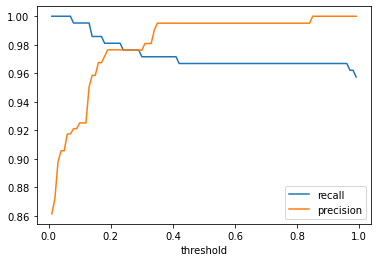

In [7]:
pr = pd.DataFrame()
pr['threshold'] = np.arange(0.01, 1, 0.01)
pr['recall'] = pr['threshold'].apply(lambda x: recall_score(y_valid, (probas >= x)))
pr['precision'] = pr['threshold'].apply(lambda x: precision_score(y_valid, (probas >= x)))

pr.plot(x='threshold')

### Question 4

<AxesSubplot:xlabel='threshold'>

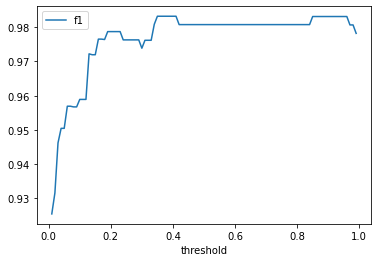

In [8]:
pr['f1'] = pr['threshold'].apply(lambda x: f1_score(y_valid, (probas >= x)))

pr.plot(x='threshold', y='f1')

### Question 5

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

aucs = np.array([])
for train_i, valid_i in kf.split(train_valid):
    X_train, y_train = train_valid.iloc[train_i][features], train_valid.iloc[train_i][target].values
    X_valid, y_valid = train_valid.iloc[valid_i][features], train_valid.iloc[valid_i][target].values
    
    pipe.fit(X_train, y_train)
    probas = pipe.predict_proba(X_valid)[:, 1]
    score = roc_auc_score(y_valid, probas)
    aucs = np.append(aucs, score)

aucs.std()

0.0027434713804377724

### Question 6

In [10]:
for c in [0.01, 0.1, 1, 10]:
    pipe = Pipeline([
        ('onehot', ct),
        ('logistic', LogisticRegression(solver='liblinear', C=c, max_iter=1000))
    ])

    aucs = np.array([])
    for train_i, valid_i in kf.split(train_valid):
        X_train, y_train = train_valid.iloc[train_i][features], train_valid.iloc[train_i][target].values
        X_valid, y_valid = train_valid.iloc[valid_i][features], train_valid.iloc[valid_i][target].values
        
        pipe.fit(X_train, y_train)
        probas = pipe.predict_proba(X_valid)[:, 1]
        score = roc_auc_score(y_valid, probas)
        aucs = np.append(aucs, score)

    print(f'C={c}, mean AUC={aucs.mean() :.5f} (std={aucs.std() :.5f})')

C=0.01, mean AUC=0.99188 (std=0.00560)
C=0.1, mean AUC=0.99506 (std=0.00395)
C=1, mean AUC=0.99645 (std=0.00274)
C=10, mean AUC=0.99639 (std=0.00282)
